In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from preprocessing import load_if_in_country_or_lang
from preprocessing import categorize_views_for_df
from processing import filter_by_region_cat_code, build_regression_dataframe, load_preprocessed_events
from plot_regression import plot_regression_results_from_dict
import numpy as np
from regression import fit_nb_with_estimated_alpha, estimate_alpha, fit_nb, standardize_var, fit_nb_with_estimated_alpha_all_codes, standardize_var

In [3]:
df_crawled = pd.read_csv('events/new/processed_0_manually_with_wikiviews.csv').drop_duplicates()

In [52]:
df_crawled.event_date.min()

'2015-11-01'

In [4]:
df_crawled = df_crawled[df_crawled.cat != 'undefined']
df_crawled = df_crawled.drop_duplicates()
df_crawled[df_crawled.pagetitle.duplicated(keep=False)]

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,in_code_lang,in_code_region,date_month,views_baseline,view_country_article


# News Value analysis:

1965 Galtung and Ruge:
- Unambiguity. The less ambiguity, the more likely the event is to become news. The more clearly an event can be understood, and interpreted without multiple meanings, the greater the chance of it being selected.
- Threshold. Events have to pass a threshold before being recorded at all. After that, the greater the intensity, the more gruesome the murder, and the more casualties in an accident - the greater the impact on the perception of those responsible for news selection.
- Unambiguity. The less ambiguity, the more likely the event is to become news. The more clearly an event can be understood, and interpreted without multiple meanings, the greater the chance of it being selected.
- Meaningfulness. The culturally similar is likely to be selected because it fits into the news selector’s frame of reference. Thus, the involvement of UK citizens will make an event in a remote country more meaningful to the UK media. Similarly, news from the USA is seen as more relevant to the UK than is news from countries which are less culturally familiar. F5. Consonance. The news selector may predict - or, indeed, want - something to happen, thus forming a mental ‘pre-image’ of an event which in turn increases its chances of becoming news.
- Unexpectedness. The most unexpected or rare events - within those that are culturally familiar and/or consonant - will have the greatest chance of being selected as news.
- Continuity. Once an event has become headline news it remains in the media spotlight for some time - even if its amplitude has been greatly reduced - because it has become familiar and easier to interpret. Continuing coverage also acts to justify the attention an event attracted in the first place.
- Composition. An event may be included as news, less because of its intrinsic news value than because it fits into the overall composition or balance of a newspaper or news broadcast. This might not just mean ‘light’ stories to balance heavy news; it could also mean that, in the context of newspaper reports on alleged institutional racism within the police, for example, positive initiatives to combat racism which would normally go unreported might make it onto the news pages.
- Reference to elite nations. The actions of elite nations are seen as more consequential than the actions of other nations. Definitions of elite nations will be culturally, politically and economically determined and will vary from country to country, although there may be universal agreement about the inclusion of some nations (eg the USA) among the elite. F10. Reference to elite people. The actions of elite people, who will usually be famous, may be seen by news selectors as having more consequence than the actions of others. Also, readers may identify with them
- Reference to persons. News has a tendency to present events as the actions of named people rather than a result of social forces. This personification goes beyond ‘human interest’ stories and could relate to ‘cultural idealism according to which man is the master of his own destiny and events can be seen as the outcome of an act of free will’.
- Reference to something negative. Negative news could be seen as unambiguous and consensual, generally more likely to be unexpected and to occur over a shorter period of time than positive news.


2001 Harcup and O'Neill:
- The power elite: Stories concerning powerful individuals, organisations or institutions.
- Celebrity: Stories concerning people who are already famous
- Entertainment: Stories concerning sex, showbusiness, human interest, animals, an unfolding drama, or offering opportunities for humorous treatment, entertaining photographs or witty headlines.
- Surprise: Stories that have an element of surprise and/or contrast.
- Bad news: Stories with particularly negative overtones, such as conflict or tragedy.
- Good news: Stories with particularly positive overtones, such as rescues and cures.
- Magnitude: Stories that are perceived as sufficiently significant either in the numbers of people involved or in potential impact.
- Relevance: Stories about issues, groups and nations perceived to be relevant to the audience.
- Follow-up: Stories about subjects already in the news.
- Newspaper agenda: Stories that set or fit the news organisation’s own agenda (Harcup and O’Neill 2001, 278–279).
    
2017 Harcup and O'Neill:
- Exclusivity: Stories generated by, or available first to, the news organisation as a result of interviews, letters, investigations, surveys, polls, and so on.
- Bad news: Stories with particularly negative overtones such as death, injury, defeat and loss (of a job, for example).
- Conflict: Stories concerning conflict such as controversies, arguments, splits, strikes, fights, insurrections and warfare.
- Surprise: Stories that have an element of surprise, contrast and/or the unusual about them.
- Audio-visuals: Stories that have arresting photographs, video, audio and/or which can be illustrated with infographics.
- Shareability: Stories that are thought likely to generate sharing and comments via Face- book, Twitter and other forms of social media.
- Entertainment: Soft stories concerning sex, showbusiness, sport, lighter human interest, animals, or offering opportunities for humorous treatment, witty headlines or lists.
- Drama: Stories concerning an unfolding drama such as escapes, accidents, searches, sieges, rescues, battles or court cases.
- Follow-up: Stories about subjects already in the news.
- The power elite: Stories concerning powerful individuals, organisations, institutions or corporations.
- Relevance: Stories about groups or nations perceived to be influential with, or culturally or historically familiar to, the audience.
- Magnitude: Stories perceived as sufficiently significant in the large numbers of people involved or in potential impact, or involving a degree of extreme behaviour or extreme occurrence.
- Celebrity: Stories concerning people who are already famous.
- Good news: Stories with particularly positive overtones such as recoveries, break- throughs, cures, wins and celebrations.
- News organisation’s agenda: Stories that set or fit the news organisation’s own agenda, whether ideological, commercial or as part of a specific campaign.

Gildersleve 2021:
- Attention features:
    - Prominence: Median pageviews in 30 days before an event
    - Magnitude: Excess of attention attributable to the event to the articles in the community. (Community article - prominence)
    - Surprise: Weighted Maximum gradient peak value in 48 hours after event.
- Relation Features
    - Uniqueness: If a story of that topic appeared in the news before, on a continuous scale. (#news reactions in parent topic/time window)
    - Follow-up: # news articles of same topic in previous week
- Event Content Features
    - Power Elite: get Wikipedia Article of person via NER, take median of partial PageRank weighted sum of pageviews of that article.
    - Proximity/Relevance: Fraction of locations mentioned in text that are of that language.
    - Good/Bad news: VADER NLP on event title
    
Ours:
- Uniqueness in 30 days before for country
- Event Content Features:
    - Power Elite/Elite Countries/Elite Organisations: GDP_pc or Economical High
    - Proximity: 
    - Relevance: Is the language of the Wikipedia edition an official language in the country where it happens?
    - Category of the event (encodes: good news/bad news a bit intrinsically)
    
It depends: Do we want to predict everything WITHOUT KNOWLEDGE WHAT HAPPENS AFTER???
    - cause then we maybe don't want to have that

In [96]:
from dateutil.relativedelta import relativedelta

n_days = 30
column = 'country'

df_col_grouped = df_crawled.groupby(['code', column, 'event_date'])['event_id'].count().rename('n_articles').reset_index()
df_col_grouped['event_date'] = pd.to_datetime(df_col_grouped.event_date)
df_col_grouped['window_unique'] = df_col_grouped.event_date - pd.to_timedelta(f'{n_days} days')
df_col_grouped['n_count'] = df_col_grouped.apply(lambda row: np.sum(df_col_grouped[(df_col_grouped.code == row.code) & (df_col_grouped[column] == row[column]) & (df_col_grouped.event_date >= row.window_unique) & (df_col_grouped.event_date < row.event_date)].n_articles), axis=1)

In [99]:
df_col_grouped[(df_col_grouped.n_count > 0)]

,code,country,event_date,n_articles,window_unique,n_count
12,de,Algeria,2018-02-16,1,2018-01-17,1
22,de,Argentina,2016-01-11,1,2015-12-12,1
23,de,Argentina,2016-02-06,1,2016-01-07,1
31,de,Argentina,2018-10-07,17,2018-09-07,2
32,de,Argentina,2018-10-08,1,2018-09-08,19
...,...,...,...,...,...,...
14128,it,United States,2020-11-15,1,2020-10-16,3
14129,it,United States,2020-11-22,1,2020-10-23,4
14130,it,United States,2020-12-18,1,2020-11-18,1
14131,it,United States,2020-12-20,1,2020-11-20,2


In [95]:
df_col_grouped[(df_col_grouped[column] == 'Afghanistan') & (df_col_grouped.event_date >= '2016-03-20') & (df_col_grouped.event_date < '2016-04-19')]

,code,country,event_date,n_articles,window_unique,n_count
2936,en,Afghanistan,2016-04-10,1,2016-03-11,0
2937,en,Afghanistan,2016-04-11,1,2016-03-12,2
2938,en,Afghanistan,2016-04-12,1,2016-03-13,3
8792,es,Afghanistan,2016-04-10,1,2016-03-11,0


In [92]:
df_col_grouped

,code,country,event_date,n_articles,window_unique,n_count
0,de,Afghanistan,2016-04-19,1,2016-03-20,4
1,de,Afghanistan,2016-07-23,1,2016-06-23,0
2,de,Afghanistan,2017-05-31,1,2017-05-01,0
3,de,Afghanistan,2017-07-24,1,2017-06-24,0
4,de,Afghanistan,2019-08-07,1,2019-07-08,0
...,...,...,...,...,...,...
14150,it,Vietnam,2016-10-13,1,2016-09-13,3
14151,it,Vietnam,2017-06-28,1,2017-05-29,0
14152,it,Zambia,2016-08-11,1,2016-07-12,0
14153,it,Zimbabwe,2017-11-14,1,2017-10-15,0


In [94]:
('2016-04-19' >= '2016-03-20') & ('2016-04-19' > '2016-07-23')

False

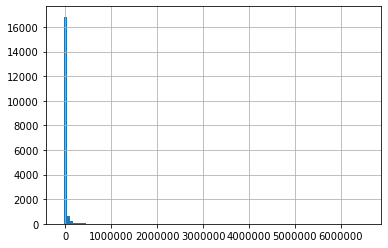

In [36]:
df_crawled.views_7_diff.hist(bins=100)

In [39]:
df_crawled.iloc[1929]

event_id                                                         Q25396697
pagetitle                Archery at the 2016 Summer Olympics – Women's ...
event_date                                                      2016-08-13
economic_region                                               Global South
country                                                             Brazil
continent                                                    South America
cat                                                                 sports
categories               ["Category:2016 in women's archery", 'Category...
views_7_sum                                                           4318
views_before_mean                                                  13124.1
views_before_sum                                                     91869
views_before_max                                                     25669
views_before_min                                                      4583
views_before_median      

In [31]:
df_crawled['views_7_diff'] = df_crawled.views_7_sum - df_crawled.views_before_sum

In [30]:
np.sum([int(num) for num in df_crawled.iloc[1111].list_views_7_days[1:-1:].split(' ')])

7662485

In [17]:
(df_crawled.views_before_median - df_crawled.views_before_mean).argmin()

1111